In [ ]:
#Checking for my GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6eb9501b-074d-00b2-cca8-b4fe43338b3c)


# Downloading the helper functions

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-03-24 07:59:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-24 07:59:05 (78.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Downloading the dataset (from kaggle)

In [ ]:
! pip install -q kaggle

In [ ]:
!pwd

/content


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sebastianvpal","key":"43bfd6d7777a503782c71ba624fc612f"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list


ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
zusmani/pakistan-toshakhana-files                                  Pakistan ToshaKhana Files                             1MB  2023-03-15 16:25:43           2404        117  1.0              
ramkrijal/tomato-daily-prices                                      Tomato Daily Prices                                  10KB  2023-03-10 15:39:14           1483         47  1.0              
themrityunjaypathak/covid-cases-and-deaths-worldwide               Covid Cases and Deaths WorldWide                      8KB  2023-02-01 12:22:51          14996        483  1.0              
datascientistanna/customers-dataset          

In [ ]:
! kaggle competitions download -c 'nlp-getting-started'

100% 593k/593k [00:00<00:00, 775kB/s]
100% 593k/593k [00:00<00:00, 775kB/s]


### Unzipping the data

In [ ]:
!ls

helper_functions.py  nlp-getting-started.zip  sample_data
kaggle.json	     __pycache__


In [ ]:
unzip_data("nlp-getting-started.zip")

In [ ]:
!ls

helper_functions.py  nlp-getting-started.zip  sample_data	     test.csv
kaggle.json	     __pycache__	      sample_submission.csv  train.csv


# Visualizing the test dataset

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
print('Number of NaN in keyword: ', train_df['keyword'].isnull().sum(), ' Numer of NaN in location: ', train_df['location'].isnull().sum())

Number of NaN in keyword:  61  Numer of NaN in location:  2533


Let's shuffle the data

In [ ]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


The test dataset doesn't have a **Target** column

Let's see how many samples of each target we have

In [ ]:
train_df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In percentage, this will be

In [ ]:
print('Percentage of zeros',round((train_df["target"].value_counts()[0] / train_df["target"].count())*100,2))
print('Percentage of ones',round((train_df["target"].value_counts()[1] / train_df["target"].count())*100,2))

Percentage of zeros 57.03
Percentage of ones 42.97


Ok, It looks like the classes are almost even

# Splitting data into train and validation

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.3,
                                                                            random_state=42)

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(5329, 5329, 2284, 2284)

# Converting text into numbers: Tokenization and then embedding

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [ ]:
max_length = 15
text_vectorizer = TextVectorization(max_tokens = 10000,
                                    output_mode='int',
                                    output_sequence_length=max_length)

Mapping our training data with the text vectorizer

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[217,   3, 236,   4,  13, 704,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

We can check the unique tokens in our vocabulary

In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

In [ ]:
print('Top words: ', top_5_words)
print('Bottom words: ', bottom_5_words)

Top words:  ['', '[UNK]', 'the', 'a', 'in']
Bottom words:  ['joseph', 'josebasedgod', 'jose', 'jorrynja', 'joonma']


## Creating the embedding, how I see this process:
from each word, it creates a vector (I define the dimension of this vector with the parameter `output_dim`) this vector is related with characteristics of the word and the other words. Similar words will have similar vector components, in a plot the will be close points.

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

In [ ]:
embedding = layers.Embedding(input_dim=10000, #Dimnesion of my vocabulary
                             output_dim=128,
                             embeddings_initializer='uniform',
                             input_length=max_length, #lengh of my input vector
                             name='embedding_1')

Also, it is really important to note that `Embeddings` are **Tensor flow layers** which means they can be trained and improve over time

# We are going to make **7** different models, the first one will be our baseline and from that one, we will try to improve our results. Our models are:
* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data

## Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.07%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating a function to evaluate our predictions

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """

  #calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 0.7907180385288967,
 'precision': 0.8126599930816301,
 'recall': 0.7907180385288967,
 'f1': 0.7825406933727875}

## Model 2: _A simple dense model_

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string') # shape is (1,) because we are giving in a vector
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, output, name='model_1_dense')

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fitting the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
167/167 [==============================] - 26s 118ms/step - loss: 0.6297 - accuracy: 0.6725 - val_loss: 0.5681 - val_accuracy: 0.7250
Epoch 2/5
167/167 [==============================] - 3s 16ms/step - loss: 0.4715 - accuracy: 0.8084 - val_loss: 0.4797 - val_accuracy: 0.7798
Epoch 3/5
167/167 [==============================] - 2s 11ms/step - loss: 0.3642 - accuracy: 0.8555 - val_loss: 0.4550 - val_accuracy: 0.7877
Epoch 4/5
167/167 [==============================] - 1s 7ms/step - loss: 0.2935 - accuracy: 0.8891 - val_loss: 0.4560 - val_accuracy: 0.7898
Epoch 5/5
167/167 [==============================] - 2s 9ms/step - loss: 0.2411 - accuracy: 0.9122 - val_loss: 0.4626 - val_accuracy: 0.7925


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

72/72 [==============================] - 0s 3ms/step - loss: 0.4626 - accuracy: 0.7925


[0.46257492899894714, 0.792469322681427]

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # It returns the probability, becuase we are using sigmoid as activation function

72/72 [==============================] - 0s 2ms/step


array([[0.42412505],
       [0.89194614],
       [0.99631774],
       [0.08975074],
       [0.14393507],
       [0.92697924],
       [0.9711702 ],
       [0.985058  ],
       [0.9236388 ],
       [0.24031372]], dtype=float32)

In [ ]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze reduces one dimension

In [ ]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 0.7924693520140105,
 'precision': 0.7977767225890728,
 'recall': 0.7924693520140105,
 'f1': 0.7889585457692997}

### Let's create a function to compare models

In [ ]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [ ]:
compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 0.79, New accuracy: 0.79, Difference: 0.00
Baseline precision: 0.81, New precision: 0.80, Difference: -0.01
Baseline recall: 0.79, New recall: 0.79, Difference: 0.00
Baseline f1: 0.78, New f1: 0.79, Difference: 0.01


It looks like our base line and dense model are pretty similar

## **Using Recurrent Neural Network (RNN)**

### Model 2: LSTM

In [ ]:
#We are creating a new embedding because it learns with training, hence, if I 
#use an already created embedding layer it won't start from zero and the 
#intercomparison between models won't be right

model_2_embedding = layers.Embedding(input_dim = 10000,
                                     output_dim=128,
                                     embeddings_initializer='uniform',
                                     input_length= max_length,
                                     name='embedding_2')

Creating the LSTM neural network

In [ ]:
inputs = layers.Input(shape=(1,), dtype= 'string')
x = text_vectorizer(inputs)
x = model_2_embedding(x)

############# this is the only part that changes ###########
x = layers.LSTM(64)(x)
############################################################
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [ ]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              )

Epoch 1/5
167/167 [==============================] - 11s 45ms/step - loss: 0.5311 - accuracy: 0.7317 - val_loss: 0.4569 - val_accuracy: 0.7920
Epoch 2/5
167/167 [==============================] - 3s 18ms/step - loss: 0.3124 - accuracy: 0.8730 - val_loss: 0.4617 - val_accuracy: 0.7868
Epoch 3/5
167/167 [==============================] - 2s 13ms/step - loss: 0.1924 - accuracy: 0.9281 - val_loss: 0.6489 - val_accuracy: 0.7684
Epoch 4/5
167/167 [==============================] - 1s 8ms/step - loss: 0.1294 - accuracy: 0.9548 - val_loss: 0.7082 - val_accuracy: 0.7513
Epoch 5/5
167/167 [==============================] - 2s 10ms/step - loss: 0.0875 - accuracy: 0.9681 - val_loss: 0.8966 - val_accuracy: 0.7561


In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)

72/72 [==============================] - 1s 3ms/step


In [ ]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

In [ ]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7561295971978984,
 'precision': 0.7558761257253425,
 'recall': 0.7561295971978984,
 'f1': 0.7544929228662169}

In [ ]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 0.79, New accuracy: 0.76, Difference: -0.03
Baseline precision: 0.81, New precision: 0.76, Difference: -0.06
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.78, New f1: 0.75, Difference: -0.03


### Model 3: GRU

In [ ]:
model_3_embedding = layers.Embedding(input_dim = 10000,
                                     output_dim=128,
                                     embeddings_initializer='uniform',
                                     input_length= max_length,
                                     name='embedding_3')

In [ ]:
inputs = layers.Input(shape=(1,), dtype= 'string')
x = text_vectorizer(inputs)
x = model_3_embedding(x)

############# this is the only part that changes ###########
x = layers.GRU(64)(x) 
############################################################
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [ ]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              )

Epoch 1/5
167/167 [==============================] - 11s 47ms/step - loss: 0.5575 - accuracy: 0.7031 - val_loss: 0.4606 - val_accuracy: 0.7846
Epoch 2/5
167/167 [==============================] - 2s 15ms/step - loss: 0.3216 - accuracy: 0.8638 - val_loss: 0.4672 - val_accuracy: 0.7859
Epoch 3/5
167/167 [==============================] - 2s 15ms/step - loss: 0.1912 - accuracy: 0.9285 - val_loss: 0.5881 - val_accuracy: 0.7789
Epoch 4/5
167/167 [==============================] - 2s 10ms/step - loss: 0.1297 - accuracy: 0.9553 - val_loss: 0.6425 - val_accuracy: 0.7566
Epoch 5/5
167/167 [==============================] - 2s 10ms/step - loss: 0.0928 - accuracy: 0.9679 - val_loss: 0.7556 - val_accuracy: 0.7570


In [ ]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
compare_baseline_to_new_results(baseline_results, model_3_results)

72/72 [==============================] - 1s 3ms/step
Baseline accuracy: 0.79, New accuracy: 0.76, Difference: -0.03
Baseline precision: 0.81, New precision: 0.76, Difference: -0.06
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.78, New f1: 0.76, Difference: -0.03


### Model 4: Bidirectional RNN model

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=10000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [ ]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              )

Epoch 1/5
167/167 [==============================] - 14s 53ms/step - loss: 0.5232 - accuracy: 0.7388 - val_loss: 0.4558 - val_accuracy: 0.7907
Epoch 2/5
167/167 [==============================] - 3s 16ms/step - loss: 0.3009 - accuracy: 0.8756 - val_loss: 0.4835 - val_accuracy: 0.7824
Epoch 3/5
167/167 [==============================] - 3s 16ms/step - loss: 0.1797 - accuracy: 0.9360 - val_loss: 0.6008 - val_accuracy: 0.7741
Epoch 4/5
167/167 [==============================] - 2s 13ms/step - loss: 0.1175 - accuracy: 0.9598 - val_loss: 0.6885 - val_accuracy: 0.7553
Epoch 5/5
167/167 [==============================] - 2s 11ms/step - loss: 0.0856 - accuracy: 0.9737 - val_loss: 0.7285 - val_accuracy: 0.7574


In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results = calculate_results(val_labels, model_4_preds)
compare_baseline_to_new_results(baseline_results, model_4_results)

72/72 [==============================] - 1s 3ms/step
Baseline accuracy: 0.79, New accuracy: 0.76, Difference: -0.03
Baseline precision: 0.81, New precision: 0.76, Difference: -0.06
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.78, New f1: 0.76, Difference: -0.03


## Model 5 Convolutional Neural Network for Text

In [ ]:
model_5_embedding = layers.Embedding(input_dim = 10000,
                                     output_dim=128,
                                     embeddings_initializer='uniform',
                                     input_length= max_length,
                                     name='embedding_5')

In [ ]:
inputs = layers.Input(shape=(1,), dtype= 'string')
x = text_vectorizer(inputs)
x = model_5_embedding(x)

############# this is the only part that changes ###########
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
############################################################
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [ ]:
# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_5.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)                 

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              )

Epoch 1/5
167/167 [==============================] - 13s 48ms/step - loss: 0.5977 - accuracy: 0.6909 - val_loss: 0.4924 - val_accuracy: 0.7767
Epoch 2/5
167/167 [==============================] - 2s 15ms/step - loss: 0.3575 - accuracy: 0.8516 - val_loss: 0.4640 - val_accuracy: 0.7863
Epoch 3/5
167/167 [==============================] - 2s 11ms/step - loss: 0.1985 - accuracy: 0.9311 - val_loss: 0.5338 - val_accuracy: 0.7745
Epoch 4/5
167/167 [==============================] - 2s 10ms/step - loss: 0.1176 - accuracy: 0.9627 - val_loss: 0.6096 - val_accuracy: 0.7697
Epoch 5/5
167/167 [==============================] - 2s 11ms/step - loss: 0.0803 - accuracy: 0.9745 - val_loss: 0.6729 - val_accuracy: 0.7636


In [ ]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
compare_baseline_to_new_results(baseline_results, model_5_results)

72/72 [==============================] - 0s 3ms/step
Baseline accuracy: 0.79, New accuracy: 0.76, Difference: -0.03
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.78, New f1: 0.76, Difference: -0.02


## Using Pretrained models

For this ocassion we are going to use the **Universal Sentence Encoder**

In [ ]:
import tensorflow_hub as hub

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


The USE will make the function of tokenizer and ebbeding, so this time we don't have to create those layers

In [ ]:
sentence_encode_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape=[],
                                       dtype=tf.string,
                                       trainable=False, #We are not going to train this
                                       name='USE')

In [ ]:
inputs = layers.Input(shape = (), dtype = 'string',name = 'input_layer')
x = sentence_encode_layer(inputs)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)
model_6 = tf.keras.Model(inputs, output, name='model_6_USE')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              )

Epoch 1/5
167/167 [==============================] - 7s 17ms/step - loss: 0.5233 - accuracy: 0.7758 - val_loss: 0.4509 - val_accuracy: 0.7995
Epoch 2/5
167/167 [==============================] - 3s 19ms/step - loss: 0.4171 - accuracy: 0.8118 - val_loss: 0.4333 - val_accuracy: 0.8052
Epoch 3/5
167/167 [==============================] - 3s 15ms/step - loss: 0.4001 - accuracy: 0.8238 - val_loss: 0.4298 - val_accuracy: 0.8047
Epoch 4/5
167/167 [==============================] - 2s 14ms/step - loss: 0.3913 - accuracy: 0.8283 - val_loss: 0.4335 - val_accuracy: 0.8091
Epoch 5/5
167/167 [==============================] - 2s 15ms/step - loss: 0.3824 - accuracy: 0.8334 - val_loss: 0.4391 - val_accuracy: 0.8095


In [ ]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_results = calculate_results(val_labels, model_6_preds)
compare_baseline_to_new_results(baseline_results, model_6_results)

72/72 [==============================] - 1s 9ms/step
Baseline accuracy: 0.79, New accuracy: 0.81, Difference: 0.02
Baseline precision: 0.81, New precision: 0.81, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.78, New f1: 0.81, Difference: 0.02


# Comparing the performance of our models

In [ ]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,0.790718,0.812660,0.790718,0.782541
simple_dense,0.792469,0.797777,0.792469,0.788959
lstm,0.756130,0.755876,0.756130,0.754493
gru,0.757005,0.756567,0.757005,0.756695
bidirectional,0.757443,0.756819,0.757443,0.756528
conv1d,0.763573,0.763106,0.763573,0.762434
tf_hub_sentence_encoder,0.809545,0.814518,0.809545,0.806679


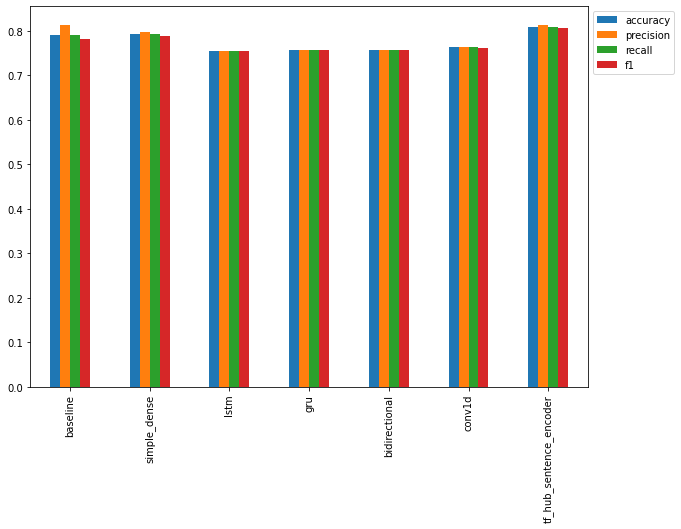

In [ ]:

# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

# Saving the model

In [ ]:
#If you save a model as a HDF5, when loading it back in, you need to let TensorFlow know about any custom objects you've used
model_6.save('model_6.h5')

In [ ]:
#If you use SavedModel format (default), you can reload your model without specifying custom objects using the tensorflow.keras.models.load_model() function
model_6.save("model_6_SavedModel_format")

# Post-processing, improving our predictions and more analyzis !!

### Combining our models

This is called **Emsemble**, one of the important things about combining different models is that they should be **uncorrelated**.
There are mainly three different approaches to work with this technique:
* **Averaging**: take the output prediction probabilities of each model for each sample, combining them and then averaging them
* **Majority of Vote**: Make predictions with each model, then the selected output will be the one with more votes
* **Model stacking**: take the outputs of each one of your chosen models and use them as inputs to another models 

Let's start using **averaging**

In [ ]:
import numpy as np

In [ ]:
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1)
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs,axis=1)  + tf.squeeze(model_6_pred_probs,axis=1)
combined_preds = tf.round(combined_pred_probs/3)

Let's calculate some metrics to see model performance

In [ ]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 0.7784588441330998,
 'precision': 0.777999363053516,
 'recall': 0.7784588441330998,
 'f1': 0.7780338226491452}

Let's implement **majority of votes**

In [ ]:
baseline_pred = np.round(np.max(model_0.predict_proba(val_sentences), axis=1))
baseline_pred


array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
model_2_pred = np.round(tf.squeeze(model_2_pred_probs,axis=1))
model_6_pred = np.round(tf.squeeze(model_6_pred_probs,axis=1))

In [ ]:
ensamble_pred = baseline_pred + model_2_pred + model_6_pred


In [ ]:
ensamble = []
for i in range(len(ensamble_pred)):
  if ensamble_pred[i] >= 2:
    ensamble.append(1)
  else:
    ensamble.append(0)
ensamble = np.array(ensamble)

In [ ]:
ensemble_results_MV = calculate_results(val_labels, ensamble)
ensemble_results_MV

{'accuracy': 0.7736427320490368,
 'precision': 0.7776218882912185,
 'recall': 0.7736427320490368,
 'f1': 0.7742384646627761}

# Finding the most wrong examples

In [ ]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.172516
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.753256
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.983753
3,@camilacabello97 Internally and externally scr...,1,0.0,0.103638
4,Radiation emergency #preparedness starts with ...,1,1.0,0.695701


let's find our model's wrong predictions

In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
881,@adorableappple No reported flooding po in the...,0,1.0,0.961113
1307,We should all have a fire safety plan. RT @Mat...,0,1.0,0.918574
1502,Two Jewish Terrorists Charged In Historic-Chur...,0,1.0,0.915417
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.898344
1620,'Dangerous' property in downtown Phoenix demol...,0,1.0,0.884668
813,Aug. 5: The Fort Calhoun Nuclear Station is at...,0,1.0,0.881362
846,Mourning notices for stabbing arson victims st...,0,1.0,0.880142
759,FedEx will no longer transport bioterror patho...,0,1.0,0.878688
769,Weapons stolen from National Guard Armory in N...,0,1.0,0.869904
1933,One thing for sure-God has promised Israel wil...,0,1.0,0.868815


# Let's try to improve our predictions

In [ ]:
train_sentences

array(['#ModiMinistry Railway Minister Prabhu calls MP derailment a natural calamity http://t.co/tL41olpAkZ',
       "Did this man just squeeze another man's head with his bare hands until it literally exploded ???????",
       'Some drugs and alcohol in Jackson Vroman house.\n\nhttp://t.co/5OQhQ8QUQV',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

In [ ]:
train_df_shuffled['keyword'][train_df_shuffled['keyword'].isnull()] = ''

<ipython-input-93-3bae91bbb3a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_shuffled['keyword'][train_df_shuffled['keyword'].isnull()] = ''


In [ ]:
train_df_shuffled['keyword'][train_df_shuffled['keyword'].isnull()]

Series([], Name: keyword, dtype: object)

In [ ]:
train_df_shuffled

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,,NaN,Officials say a quarantine is in place at an A...,1


There are only 222 unique **KeyWords**, which is surprising giving that there are 7613 tweets

In [ ]:
len(train_df_shuffled['keyword'].unique())

222

In [ ]:
train_df_shuffled['keyword'][37]

'ablaze'

In [ ]:
for i in train_df_shuffled['keyword'].unique():
    for j in range(len(train_df_shuffled['keyword'])):
      if train_df_shuffled['keyword'].iloc[j] == i:
        


2644     True
2227    False
5448    False
132     False
6845    False
        ...  
5226    False
5390    False
860     False
7603    False
7270    False
Name: keyword, Length: 7613, dtype: bool

In [ ]:
train_df_v2 = '"' + train_df_shuffled['keyword'] + '"' + ' ' + train_df_shuffled['text']  
print(train_df_v2[40], train_df_shuffled['target'][40])

"ablaze" Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw 0


In [ ]:
train_sentences_v2, val_sentences_v2, train_labels_v2, val_labels_v2 = train_test_split(train_df_v2.to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.3,
                                                                            random_state=42)

In [ ]:
!pip install "tensorflow-text==2.11.*"
!pip install bokeh
!pip install simpleneighbors[annoy]
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 71.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully unin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.0/648.0 KB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.1-cp39-cp39-linux_x86_64.whl size=580981 sha256=23f884d20794b8c4ac76d4450984aa1f811e435f96aafee2edf2f62448b702c7
  Stored in directory: /root/.cache/pip/wheels/5b/7d/31/9a9a4993d085bc85bee21946bce94cd5906ce99730f5467e57
Successfully built annoy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow.compat.v2 as tf
from tensorflow_text import SentencepieceTokenizer

In [ ]:
USE_link = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'
sentence_encode_layer_v2 = hub.KerasLayer(USE_link,
                                       input_shape=[],
                                       dtype=tf.string,
                                       trainable=False, #We are not going to train this
                                       name='USE_multilingual')

In [ ]:
inputs = layers.Input(shape = (), dtype = 'string',name = 'input_layer')
x = sentence_encode_layer_v2(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(4, activation='relu')(x)
x = layers.Dense(2, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)
model_6_v2 = tf.keras.Model(inputs, output, name='model_6_USE')

In [ ]:
#for layer_number, layer in enumerate(model_6_v2.layers):
#  print(layer_number, layer.name, layer.trainable)

In [ ]:
#sentence_encode_layer.traibable = True

In [ ]:
#for layer_number, layer in enumerate(sentence_encode_layer.layers):
#  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Compile model
model_6_v2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6_v2.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 USE_multilingual (KerasLaye  (None, 512)              68927232  
 r)                                                              
                                                                 
 dense_33 (Dense)            (None, 128)               65664     
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 32)                2080      
                                                                 
 dense_36 (Dense)            (None, 16)                528       
                                                       

Adding a callback to stop the training in case no improvemnet is achieved and to change the learning rate 

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_accuracy", factor=0.5, patience=4,verbose=1,min_lr=1e-7)

In [ ]:
model_6_history_v2 = model_6_v2.fit(train_sentences_v2,
                              train_labels_v2,
                              epochs=10,
                              validation_data=(val_sentences_v2, val_labels_v2))

Epoch 1/10
167/167 [==============================] - 11s 39ms/step - loss: 0.5861 - accuracy: 0.6814 - val_loss: 0.5647 - val_accuracy: 0.7850
Epoch 2/10
167/167 [==============================] - 3s 21ms/step - loss: 0.5159 - accuracy: 0.8129 - val_loss: 0.5376 - val_accuracy: 0.8017
Epoch 3/10
167/167 [==============================] - 3s 20ms/step - loss: 0.4814 - accuracy: 0.8294 - val_loss: 0.5450 - val_accuracy: 0.8025
Epoch 4/10
167/167 [==============================] - 5s 30ms/step - loss: 0.4500 - accuracy: 0.8461 - val_loss: 0.5347 - val_accuracy: 0.7990
Epoch 5/10
167/167 [==============================] - 4s 25ms/step - loss: 0.4100 - accuracy: 0.8634 - val_loss: 0.5329 - val_accuracy: 0.7925
Epoch 6/10
167/167 [==============================] - 3s 21ms/step - loss: 0.3669 - accuracy: 0.8848 - val_loss: 0.5415 - val_accuracy: 0.7863
Epoch 7/10
167/167 [==============================] - 4s 22ms/step - loss: 0.3281 - accuracy: 0.8985 - val_loss: 0.5679 - val_accuracy: 0.789

In [ ]:

model_6_pred_probs_v2 = model_6_v2.predict(val_sentences)
model_6_preds_v2 = tf.squeeze(tf.round(model_6_pred_probs_v2))
model_6_results_v2 = calculate_results(val_labels, model_6_preds_v2)
model_6_results_v2

In [ ]:
model_6_pred_probs_v2 = model_6_v2.predict(val_sentences)
model_6_preds_v2 = tf.squeeze(tf.round(model_6_pred_probs_v2))
model_6_results_v2 = calculate_results(val_labels, model_6_preds_v2)
model_6_results_v2

72/72 [==============================] - 3s 16ms/step


{'accuracy': 0.8099824868651488,
 'precision': 0.8130089994101727,
 'recall': 0.8099824868651488,
 'f1': 0.8077583554351411}

In [ ]:
# Create dataframe with validation sentences and best performing model predictions
val_df_v2 = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds_v2,
                       "pred_prob": tf.squeeze(model_6_pred_probs_v2)})
val_df_v2


,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.098315
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.953992
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.992219
3,@camilacabello97 Internally and externally scr...,1,0.0,0.114395
4,Radiation emergency #preparedness starts with ...,1,0.0,0.452397
...,...,...,...,...
2279,Typhoon Soudelor was captured in this incredib...,1,1.0,0.991868
2280,WA smiles after July deluge - The West Austral...,0,0.0,0.014711
2281,Earthquake and tsunami that occurred in Japan ...,1,1.0,0.976720
2282,Ancient Mayan Tablet with Hieroglyphics Honors...,0,0.0,0.077082


In [ ]:
val_df_v2[val_df_v2['target']==val_df_v2['pred']]

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.098315
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.992219
5,Investigators rule catastrophic structural fai...,1,1.0,0.885763
6,How the West was burned: Thousands of wildfire...,1,1.0,0.993188
7,Map: Typhoon Soudelor's predicted path as it a...,1,1.0,0.998813
...,...,...,...,...
2279,Typhoon Soudelor was captured in this incredib...,1,1.0,0.991868
2280,WA smiles after July deluge - The West Austral...,0,0.0,0.014711
2281,Earthquake and tsunami that occurred in Japan ...,1,1.0,0.976720
2282,Ancient Mayan Tablet with Hieroglyphics Honors...,0,0.0,0.077082
